In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch.quantization
import torchvision.transforms.functional as TF

In [27]:
from google.colab import drive
drive.mount(('/content/drive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%%time

import tarfile

path = "/content/drive/MyDrive/LaPa.tar.gz"
extract_path = "/tmp"

# Open the tar.gz file
with tarfile.open(path, "r:gz") as tar:
    # Extract all contents to /tmp
    tar.extractall(path=extract_path)

CPU times: user 23.1 s, sys: 14.2 s, total: 37.3 s
Wall time: 58.2 s


In [29]:
# Define paths to the subfolders
train_path = os.path.join("/tmp/LaPa/train")
test_path = os.path.join("/tmp/LaPa/test")
validation_path = os.path.join("/tmp/LaPa/val")

# Define paths to the images subfolder in each dataset split
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
validation_images_path = os.path.join(validation_path, "images")

# List files in each subfolder
print("Train files:", os.listdir(train_path))
print("Test files:", os.listdir(test_path))
print("Validation files:", os.listdir(validation_path))
print("__________________________________________")

# print("Train images:", os.listdir(train_images_path))
# print("Test images:", os.listdir(test_images_path))
# print("Validation images:", os.listdir(validation_images_path))
# print("__________________________________________")

# Define paths to the landmarks subfolder in each dataset split
train_landmarks_path = os.path.join(train_path, "landmarks")
test_landmarks_path = os.path.join(test_path, "landmarks")
validation_landmarks_path = os.path.join(validation_path, "landmarks")

# print("Train landmarks:", os.listdir(train_landmarks_path))
# print("Test landmarks:", os.listdir(test_landmarks_path))
# print("Validation landmarks:", os.listdir(validation_landmarks_path))
# print("__________________________________________")

# Define paths to the labels subfolder in each dataset split
train_labels_path = os.path.join(train_path, "labels")[:1500]
test_labels_path = os.path.join(test_path, "labels")[:400]
validation_labels_path = os.path.join(validation_path, "labels")[:200]

# print("Train labels:", os.listdir(train_labels_path))
# print("Test labels:", os.listdir(test_labels_path))
# print("Validation labels:", os.listdir(validation_labels_path))
# print("__________________________________________")

Train files: ['images', 'landmarks', 'labels']
Test files: ['images', 'landmarks', 'labels']
Validation files: ['images', 'landmarks', 'labels']
__________________________________________


In [30]:
# Save checkpoint
def save_checkpoint(state,filename='UNET.weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(filename,model,optim,device):
    print('Loading weights-->')
    checkpoint = torch.load(filename, map_location=device)
    #checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

    # Move the model and optimizer to the correct device
    model.to(device)
    for state in optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)



In [31]:
'''   NOT USED   '''


# We need to generate 1 single mask from all masks
# First we retrieve all masks associated with current image

def generate_image_from_masks(mask,original_image):
    custom_colors = np.array([
    [0, 0, 0],
    [0, 153, 255],
    [102, 255, 153],
    [0, 204, 153],
    [255, 255, 102],
    [255, 255, 204],
    [255, 153, 0],
    [255, 102, 255],
    [102, 0, 51],
    [255, 204, 255],
    [255, 0, 102]])
    h, w = mask.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            class_value = mask[y, x]
            rgb_image[y, x] = custom_colors[class_value]
    return rgb_image

def normalise_image(image): # not used currently, lets add based on performance
    # perform mean and std deviation normalization
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [32]:
# Data Visualization
i = 22
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
# mask_img = cv2.resize(mask_img, (512, 512))
# mask_img = generate_image_from_masks(mask_img,image_rgb)

print(image_bgr.shape)
print(mask_img.shape)

(1166, 1158, 3)
(1166, 1158)


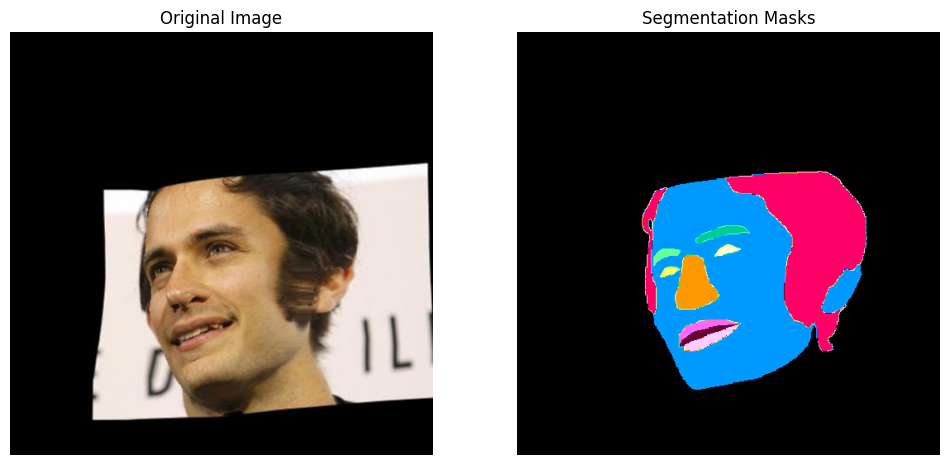

In [33]:
# Data Visualization
i = 90
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(mask_img, (512, 512))
mask_img = generate_image_from_masks(mask_img,image_rgb)

# Display original and mask images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
axes[0].imshow(image_rgb)  # Display original image
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis
axes[1].imshow(mask_img)  # Display composite image with masks
axes[1].set_title('Segmentation Masks')
axes[1].axis('off')  # Hide axis
plt.show()

# LAPA + transform

In [34]:
def my_img_mask_transforms(image, mask):
    resize = transforms.Resize((512, 512))
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    image = resize(image)
    mask = resize(mask)

    seed = 2024
    random.seed(seed)
    torch.manual_seed(seed)

    if random.random() > 0.5:
          angle = random.randint(-30, 30)
          image = TF.rotate(image, angle)
          mask = TF.rotate(mask, angle)

    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # if random.random() > 0.5:
    #     image = TF.vflip(image)
    #     mask = TF.vflip(mask)

    image = totensor(image)
    image = normalize(image)
    mask = torch.tensor(np.array(mask), dtype=torch.float32)

    return image, mask



class Lapa(Dataset):
    def __init__(self, images_dir, masks_dir, size):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images", "labels").replace("jpg", "png")

        # Open image
        image = Image.open(img_path).convert("RGB")

        # Open mask and convert to PIL Image
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_img = Image.fromarray(cv2.resize(mask_img, (512, 512)))


        image, mask_img = my_img_mask_transforms(image, mask_img)

        # Split the masks
        binary_masks = []
        for class_value in range(0, 11):
            binary_mask = (mask_img == class_value).float()
            binary_masks.append(binary_mask)

        return image, torch.stack(binary_masks, dim=0)

In [35]:
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1100)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   250)


Image 0 is tensor: True


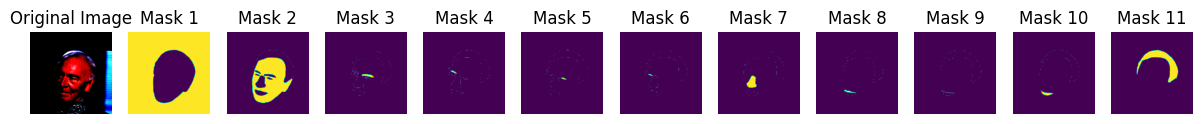

Image 1 is tensor: True


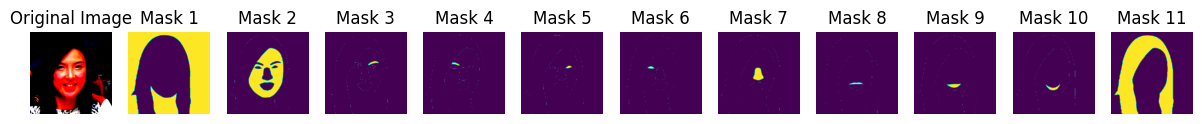

Image 2 is tensor: True


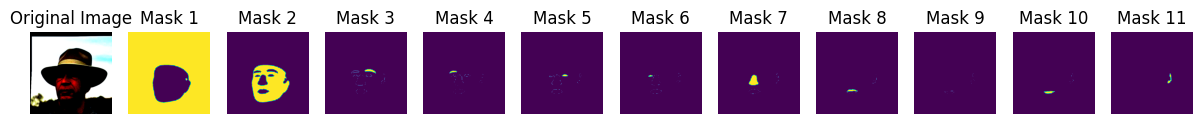

Image 3 is tensor: True


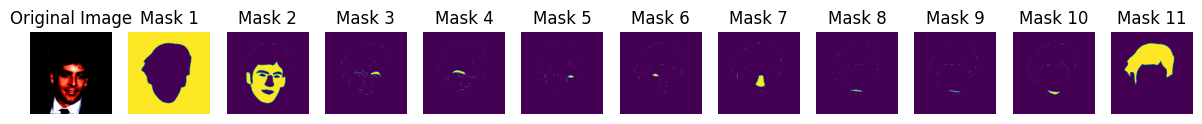

Image 4 is tensor: True


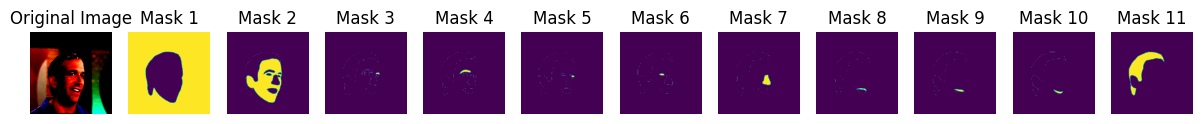

In [36]:
for i in range(5):  # Change the range as needed
    t = train_dataset[i]
    img = np.array(t[0].permute(1, 2, 0))
    print(f"Image {i} is tensor: {isinstance(t[1], torch.Tensor)}")
    mask = np.array(t[1])

    num_masks = mask.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 15))

    # Display the original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display each mask
    for m in range(num_masks):
        axes[m + 1].imshow(mask[m])
        axes[m + 1].set_title(f'Mask {m + 1}')
        axes[m + 1].axis('off')

    plt.show()

# Train/Val loader - train_loop - test_loop

In [37]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [38]:
def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            #scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch + 1, moving_loss))



In [12]:
# def test_loop(model,dataloader,loss_fun,device):
#     model.eval()
#     model.to(device)
#     losses = []
#     loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
#     with torch.no_grad():
#         for batch,(x,y) in loop:
#             # put on cuda
#             x = x.to(device)
#             y = y.to(device)

#             # forward pass
#             y_pred = model(x)

#             # caclulate test loss
#             loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
#             losses.append(loss.detach().item())

#             # Update TQDM progress bar
#             loop.set_postfix(loss=loss.item())

In [40]:
# def test_loop(model, dataloader, loss_fun, device):
#     model.eval()
#     model.to(device)
#     losses = []
#     all_predictions = []
#     all_ground_truth = []

#     loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
#     with torch.no_grad():
#         for batch, (x, y) in loop:
#             # put on cuda
#             x = x.to(device)
#             y = y.to(device)

#             # forward pass
#             y_pred = model(x)

#             # calculate test loss
#             loss = loss_fun(y_pred, y)
#             losses.append(loss.detach().item())

#             all_predictions.append(y_pred.cpu())
#             all_ground_truth.append(y.cpu())

#             # Update TQDM progress bar
#             loop.set_postfix(loss=loss.item())

#     all_predictions = torch.cat(all_predictions, dim=0)
#     all_ground_truth = torch.cat(all_ground_truth, dim=0)

#     # Compute metrics
#     iou_scores, dice_scores, mIoU = compute_metrics(all_predictions, all_ground_truth)

#     avg_loss = sum(losses) / len(losses)
#     print(f'Test Loss: {avg_loss:.4f}')
#     print(f'Mean IoU: {mIoU:.4f}')
#     return iou_scores, dice_scores, mIoU

# def compute_metrics(pred_masks, true_masks):
#     num_images, num_masks, _, _ = pred_masks.shape
#     iou_scores = []
#     dice_scores = []

#     for img_idx in range(num_images):
#         for mask_idx in range(num_masks):
#             pred_mask = pred_masks[img_idx, mask_idx].detach().cpu()
#             true_mask = true_masks[img_idx, mask_idx].cpu()

#             threshold = 0
#             pred_mask = (pred_mask > threshold).int()
#             true_mask = true_mask.int()

#             intersection = (pred_mask & true_mask).float().sum().item()
#             union = (pred_mask | true_mask).float().sum().item()

#             iou = intersection / union if union != 0 else 0
#             dice = 2 * intersection / (pred_mask.sum().item() + true_mask.sum().item())

#             iou_scores.append(iou)
#             dice_scores.append(dice)

#     mIoU = np.mean(iou_scores)

#     return iou_scores, dice_scores, mIoU




def test_loop(model, dataloader, loss_fun, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0

    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch, (x, y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate test loss
            loss = loss_fun(y_pred, y)
            total_loss += loss.item()

            # Compute metrics for the batch
            batch_iou, batch_dice = compute_batch_metrics(y_pred, y)
            total_iou += batch_iou
            total_dice += batch_dice

            num_batches += 1

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches

    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Mean IoU: {avg_iou:.4f}')
    print(f'Mean Dice: {avg_dice:.4f}')

    return avg_iou, avg_dice

def compute_batch_metrics(pred_masks, true_masks, threshold=0.0):
    pred_masks = (pred_masks > threshold).int()
    true_masks = true_masks.int()

    intersection = (pred_masks & true_masks).float().sum(dim=[2, 3])
    union = (pred_masks | true_masks).float().sum(dim=[2, 3])
    iou = intersection / (union)
    dice = 2 * intersection / (pred_masks.float().sum(dim=[2, 3]) + true_masks.float().sum(dim=[2, 3]))

    mean_iou = iou.mean().item()
    mean_dice = dice.mean().item()

    return mean_iou, mean_dice

# UNET

In [41]:
# Define segmentation architectures
class VanillaUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(VanillaUNet, self).__init__()
        # Encode architecture
        self.dconv1 = self._double_conv(in_channels, 64)
        self.dconv2 = self._double_conv(64, 128)
        self.dconv3 = self._double_conv(128, 256)
        self.dconv4 = self._double_conv(256, 512)
        self.dconv5 = self._double_conv(512, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512,256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256,128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128,64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dconv1(X)              # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.max_pool(X1)           # X2 Shape : [B X 64 X 256 X 256]

        X3 = self.dconv2(X2)             # X3 Shape : [B X 128 X 256 X 256]
        X4 = self.max_pool(X3)           # X4 Shape : [B X 128 X 128 X 128]

        X5 = self.dconv3(X4)             # X5 Shape : [B X 256 X 128 X 128]
        X6 = self.max_pool(X5)           # X6 Shape : [B X 256 X 64 X 64]

        X7 = self.dconv4(X6)             # X7 Shape : [B X 512 X 64 X 64]
        X8 = self.max_pool(X7)           # X8 Shape : [B X 512 X 32 X 32]

        X9 = self.dconv5(X8)             # X9 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X10 = self.uconv1(X9)            # X10 Shape : [B X 512 X 64 X 64]
        X11 = torch.cat((X10,X7),dim=1)  # X11 Shape : [B X 1024 X 64 X 64]
        X12 = self.dconv6(X11)           # X12 Shape : [B X 512 X 64 X 64]

        X13 = self.uconv2(X12)           # X13 Shape : [B X 256 X 128 X 128]
        X14 = torch.cat((X13,X5),dim=1)  # X14 Shape : [B X 512 X 128 X 128]
        X15 = self.dconv7(X14)           # X15 Shape : [B X 256 X 128 X 128]

        X16 = self.uconv3(X15)            # X16 Shape : [B X 128 X 256 X 256]
        X17 = torch.cat((X16,X3),dim=1)   # X17 Shape : [B X 256 X 256 X 256]
        X18 = self.dconv8(X17)            # X18 Shape : [B X 128 X 256 X 256]

        X19 = self.uconv4(X18)            # X19 Shape : [B X 64 X 512 X 512]
        X20 = torch.cat((X19,X1),dim=1)   # X20 Shape : [B X 128 X 512 X 512]
        X21 = self.dconv9(X20)            # X21 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X22 = self.final_conv(X21)        # X22 Shape : [B X num_classes X 512 X 512]

        return X22 #F.softmax(X22,dim=1)

In [42]:
model = VanillaUNet(in_channels=3,num_classes=11)

In [43]:
# Params
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

num_epochs = 1
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [17]:
# Define Criterion, Loss function, LR Scheduler
# criterion = CustomLoss()
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [47]:
''' WEIGHTS after 10 EPOCHS '''
load_checkpoint("/content/drive/MyDrive/UNET.weights.pth_novflip_5plus5epochs.tar", model, optimizer, device)


Loading weights-->


In [48]:
train_loop(model,train_loader,criterion,optimizer, device)

Epoch [0/1] : 100%|██████████| 550/550 [05:09<00:00,  1.78it/s, loss=0.0633]


Saving weights-->
Epoch 1 : Loss = 0.06078886841169812


In [49]:
avg_iou, avg_dice = test_loop(model, val_loader, criterion, device)

100%|██████████| 125/125 [00:30<00:00,  4.07it/s, loss=0.0328]

Test Loss: 0.0756
Mean IoU: 0.2573
Mean Dice: 0.3106


In [56]:
it = iter(val_loader)
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

In [21]:
def compute_metrics(pred_masks, true_masks):
    iou_scores = []
    dice_scores = []

    for pred_mask, true_mask in zip(pred_masks, true_masks):
        pred_mask, true_mask = pred_mask.detach().cpu(), true_mask.cpu()
        threshold = 0
        pred_mask = (pred_mask > threshold).int()
        true_mask = true_mask.int()
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)

        dice = 2 * intersection / (pred_mask.sum() + true_mask.sum())
        dice_scores.append(dice)

    mIoU = np.mean(iou_scores)

    return iou_scores, dice_scores, mIoU

In [51]:
iou_scores, dice_scores, mIoU = compute_metrics(pred, mask)
print(iou_scores, dice_scores, mIoU)

[tensor(0.8911), tensor(0.8461)] [tensor(0.9424), tensor(0.9166)] 0.8686199


<ipython-input-67-6609cc41290f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

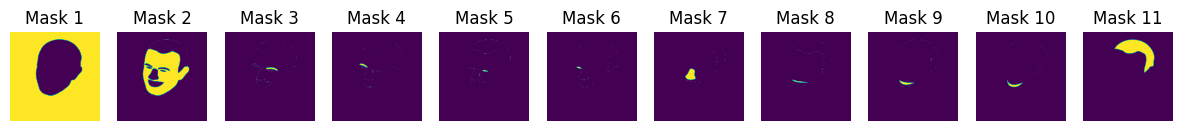

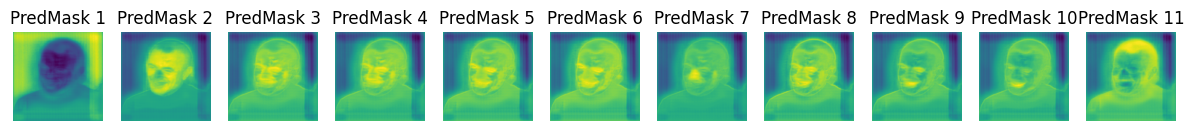

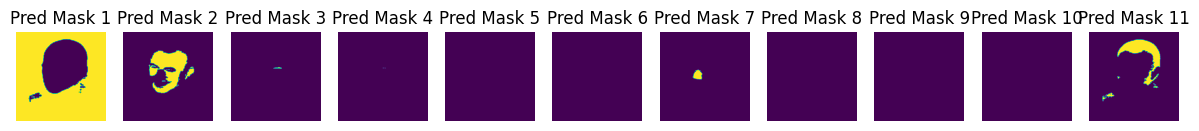

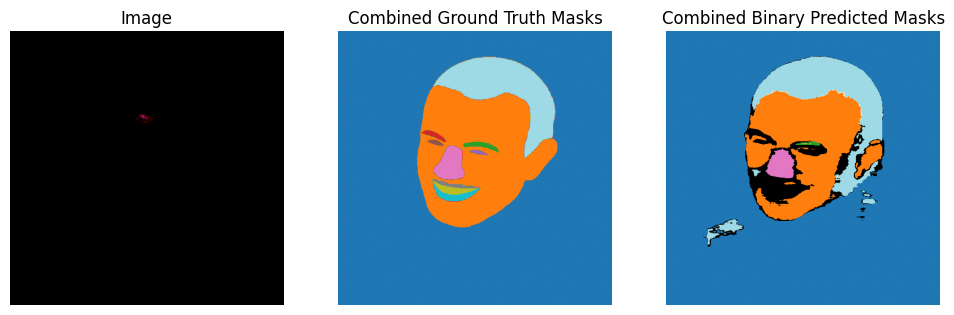

In [67]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig3, axes3 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[0][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[0][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    for m in range(num_masks):
        binary_pred = (pred[0][m] > 0.0).float()
        axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
        axes2[m].set_title(f'Pred Mask {m + 1}')
        axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color
        binary_pred = (pred[0, m] > 0.0).float()
        combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes3[0].imshow(np.array(image[0].permute(1,2,0).cpu()))
    axes3[0].set_title('Image')
    axes3[0].axis('off')

    axes3[1].imshow(combined_mask)
    axes3[1].set_title('Combined Ground Truth Masks')
    axes3[1].axis('off')

    axes3[2].imshow(combined_binary_pred)
    axes3[2].set_title('Combined Binary Predicted Masks')
    axes3[2].axis('off')


<ipython-input-69-f8495b1dc188>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

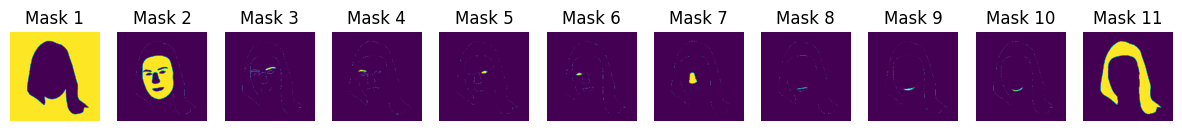

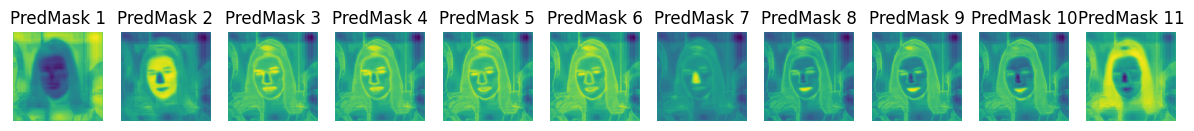

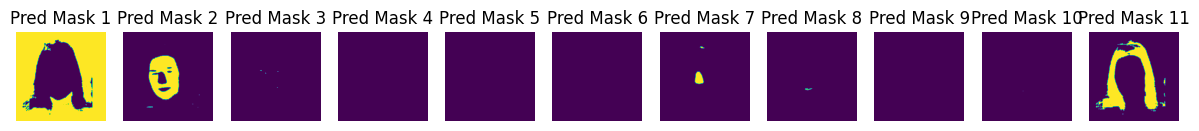

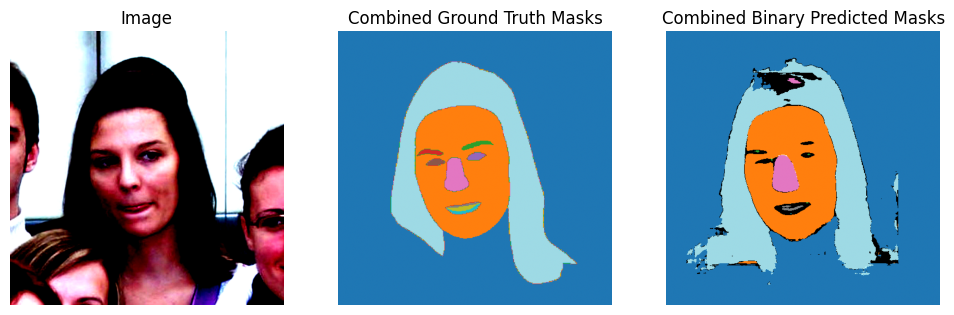

In [69]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig3, axes3 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    for m in range(num_masks):
        binary_pred = (pred[1][m] > 0.0).float()
        axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
        axes2[m].set_title(f'Pred Mask {m + 1}')
        axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color
        binary_pred = (pred[1, m] > 0.0).float()
        combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes3[0].imshow(np.array(image[1].permute(1,2,0).cpu()))
    axes3[0].set_title('Image')
    axes3[0].axis('off')

    axes3[1].imshow(combined_mask)
    axes3[1].set_title('Combined Ground Truth Masks')
    axes3[1].axis('off')

    axes3[2].imshow(combined_binary_pred)
    axes3[2].set_title('Combined Binary Predicted Masks')
    axes3[2].axis('off')


In [70]:
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

In [73]:
iou_scores, dice_scores, mIoU = compute_metrics(pred, mask)
print(iou_scores, dice_scores, mIoU)

[tensor(0.7259), tensor(0.8603)] [tensor(0.8412), tensor(0.9249)] 0.7930763


<ipython-input-71-6609cc41290f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

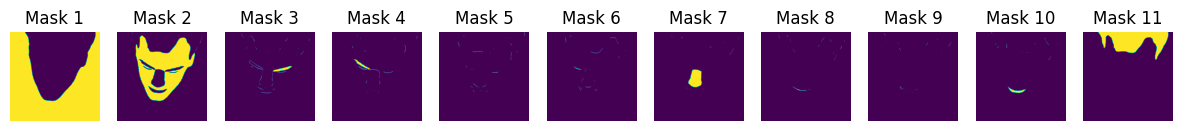

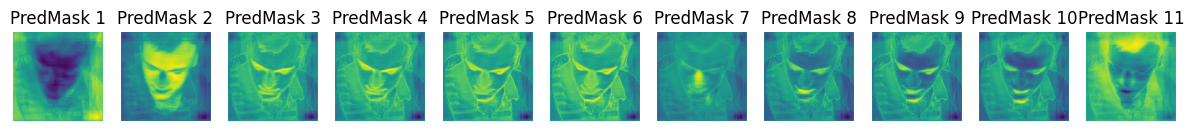

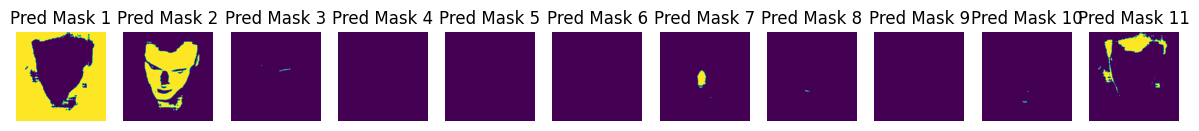

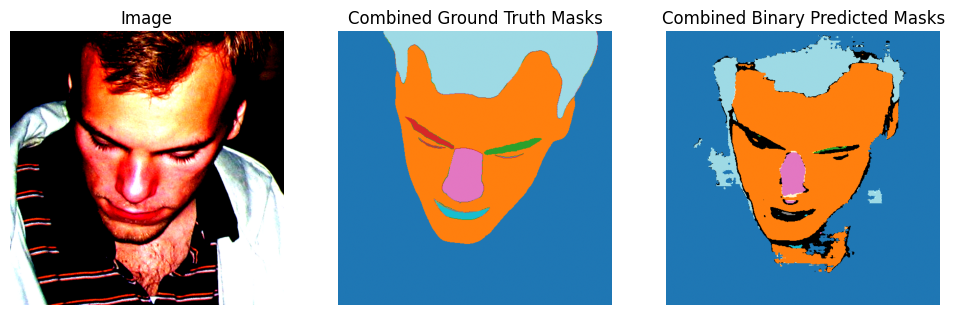

In [71]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig3, axes3 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[0][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[0][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    for m in range(num_masks):
        binary_pred = (pred[0][m] > 0.0).float()
        axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
        axes2[m].set_title(f'Pred Mask {m + 1}')
        axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color
        binary_pred = (pred[0, m] > 0.0).float()
        combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes3[0].imshow(np.array(image[0].permute(1,2,0).cpu()))
    axes3[0].set_title('Image')
    axes3[0].axis('off')

    axes3[1].imshow(combined_mask)
    axes3[1].set_title('Combined Ground Truth Masks')
    axes3[1].axis('off')

    axes3[2].imshow(combined_binary_pred)
    axes3[2].set_title('Combined Binary Predicted Masks')
    axes3[2].axis('off')


<ipython-input-72-f8495b1dc188>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


(-0.5, 511.5, 511.5, -0.5)

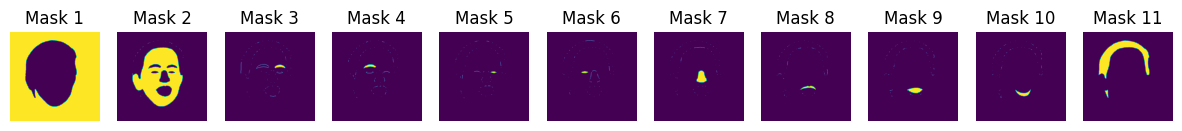

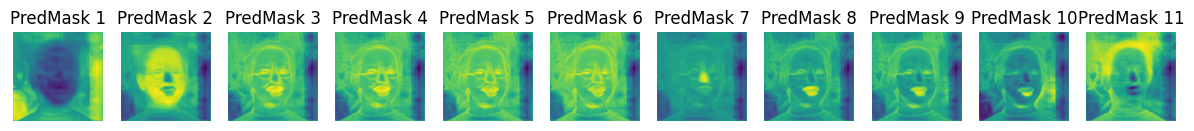

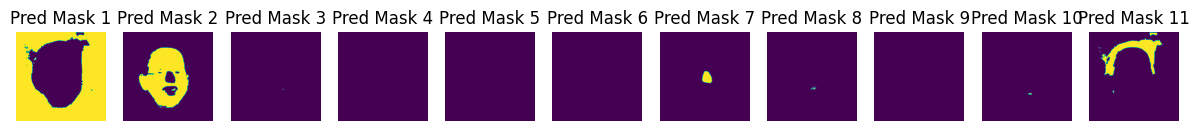

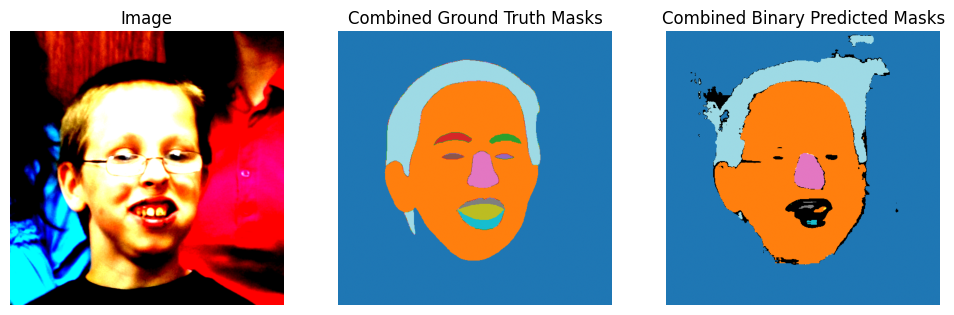

In [72]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig3, axes3 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    for m in range(num_masks):
        binary_pred = (pred[1][m] > 0.0).float()
        axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
        axes2[m].set_title(f'Pred Mask {m + 1}')
        axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color
        binary_pred = (pred[1, m] > 0.0).float()
        combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes3[0].imshow(np.array(image[1].permute(1,2,0).cpu()))
    axes3[0].set_title('Image')
    axes3[0].axis('off')

    axes3[1].imshow(combined_mask)
    axes3[1].set_title('Combined Ground Truth Masks')
    axes3[1].axis('off')

    axes3[2].imshow(combined_binary_pred)
    axes3[2].set_title('Combined Binary Predicted Masks')
    axes3[2].axis('off')
